## (0) Libraries 📚

In [2]:
import pandas as pd

##  (1) Dataset 💾

### Lyrics dataset

In [2]:
df = pd.read_csv('/Users/laureenwilhelm/code/vicctoirec/wagon-bootcamp-project/raw_data/20250609_17k_lyrics_eng_fr.csv')

In [3]:
df.head()

,Unnamed: 0,artist,track_title_clean,lyrics_clean,artist_lower,track_title_clean_lower
0,0,ABBA,"Andante, Andante","Take it easy with me, please Touch me gently l...",abba,"andante, andante"
1,1,ABBA,As Good As New,I'll never know why I had to go Why I had to p...,abba,as good as new
2,2,ABBA,Bang-A-Boomerang,Making somebody happy is a question of give an...,abba,bang-a-boomerang
3,3,ABBA,Cassandra,Down in the street they're all singing and sho...,abba,cassandra
4,4,ABBA,Chiquitita,"Chiquitita, tell me what's wrong You're enchai...",abba,chiquitita


###  (1.1) Basic Info ℹ️

In [4]:
df.shape

(17304, 6)

In [5]:
df.dtypes

Unnamed: 0                  int64
artist                     object
track_title_clean          object
lyrics_clean               object
artist_lower               object
track_title_clean_lower    object
dtype: object

###  (1.2) Pre-cleaning 🕵🏻‍♂️

* 👥 Remove duplicates
* ❓ Have a first glimpse at the missing values
* 😏 Detect the weird columns
* ⚖️ Detect class imbalances for classification tasks and outliers for regression tasks

***Duplicates***

In [6]:
nb_of_duplicated_rows = df.duplicated().sum()
nb_of_duplicated_rows

0

***Missing values???***

In [7]:
df.isna().sum().sort_values(ascending=False)

lyrics_clean               3
Unnamed: 0                 0
artist                     0
track_title_clean          0
artist_lower               0
track_title_clean_lower    0
dtype: int64

In [8]:
df.isna().mean().sort_values(ascending=False)

lyrics_clean               0.000173
Unnamed: 0                 0.000000
artist                     0.000000
track_title_clean          0.000000
artist_lower               0.000000
track_title_clean_lower    0.000000
dtype: float64

In [9]:
df = df.dropna(subset=['lyrics_clean'])

In [10]:
df.isna().sum().sort_values(ascending=False)

Unnamed: 0                 0
artist                     0
track_title_clean          0
lyrics_clean               0
artist_lower               0
track_title_clean_lower    0
dtype: int64

## (2)💈 Preprocessing minimal pour baseline

In [3]:
import re

# Fonction pour prétraiter les paroles
def preprocess_lyrics(lyrics):
    lyrics = lyrics.lower()
    lyrics = re.sub(r'[^\w\s]', '', lyrics)  # retire la ponctuation
    return lyrics

In [12]:
# Appliquer la fonction de prétraitement aux paroles
df['lyrics_clean'] = df['lyrics_clean'].apply(preprocess_lyrics)

In [13]:
# Afficher les premières lignes du DataFrame après le prétraitement
df['lyrics_clean'].head()

0    take it easy with me please touch me gently li...
1    ill never know why i had to go why i had to pu...
2    making somebody happy is a question of give an...
3    down in the street theyre all singing and shou...
4    chiquitita tell me whats wrong youre enchained...
Name: lyrics_clean, dtype: object

In [18]:
import random

# Fonction pour obtenir un morceau aléatoire contenant un mot-clé
def get_random_track_containing(keyword):
    keyword = keyword.lower()
    filtered = df[df['lyrics_clean'].str.contains(keyword)]
    filtered = filtered.reset_index(drop=True)
    if filtered.empty:
        return None

    random_index = random.randint(0, len(filtered) - 1)
    selected_row = filtered.iloc[random_index]

    return {
        'artist' : selected_row['artist'],
        'Title' : selected_row['track_title_clean']}

In [19]:
# Exemple d'utilisation de la fonction
get_random_track_containing('love')

{'artist': 'Nightwish', 'Title': 'Planet Hell'}

## (2)💈Preprocessing feature 2 du MVP

🎯 Objectif recapitulé
Input : "Je pars en Italie, j’aime le soleil"

Output :
Les 10 meilleures chansons dont les lyrics_clean matchent fortement (≥ 0.9) avec les thèmes extraits de cette envie.

##### Input utilisateur = Envie libre 

In [4]:
user_input = "I'm happy, I love Italy"

##### Zero-Shot classification : Boucle sur lyric_clean
- On compare chaque chanson à l'envie comme si l'envie était une classe potentielle 
- On utilise le modele facebook/bart-large-mnli, avec multi_label=True

In [15]:
from transformers import pipeline
from tqdm import tqdm
import textwrap

# Set up classifier
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Preprocess function
def chunk_text(text, max_words=250):
    return textwrap.wrap(text, max_words)


def get_zeroshot_score(lyrics, user_label):
    chunks = chunk_text(lyrics)
    scores = []
    for chunk in chunks:
        try:
            result = classifier(chunk, candidate_labels=[user_label], multi_label=True)
            scores.append(result['scores'][0]) # Get the score for the first label
        except:
            continue
    return max(scores) if scores else None


/Users/laureenwilhelm/.pyenv/versions/3.10.6/envs/wagon-bootcamp-project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Test sur un bout du DF pour easier debug 

In [25]:
df_sample = df.sample(n=1000, random_state=42)  # random_state pour la reproductibilité

100%|██████████| 1000/1000 [16:20<00:00,  1.02it/s]


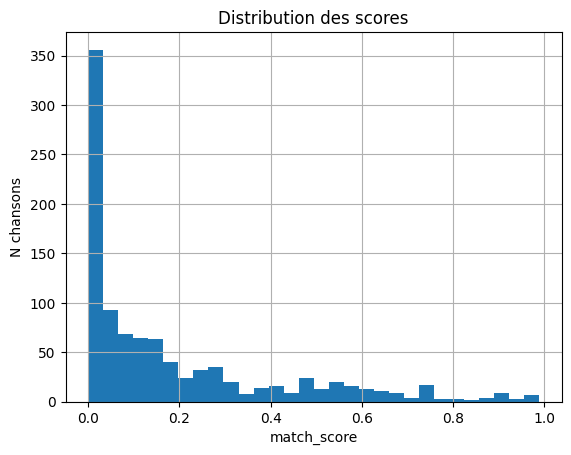

,artist,track_title_clean,match_score
3763,Billy Joel,Scenes From An Italian Restaurant,0.988472
2885,Tim McGraw,Two Lanes Of Freedom,0.976050
2626,Rush,Presto,0.966236
9792,Kendji Girac,Color Gitano,0.964185
10403,Daniel Guichard,Faire Semblant,0.962416
2145,Opeth,The Twilight Is My Robe,0.960679
13560,Koba LaD,Honey,0.957406
13155,SCH,Corrida,0.937814
15594,The Pirouettes,Carrément carrément,0.924745
14807,Carla Bruni,Il Vecchio E Il Bambino,0.922958


In [26]:
# Progress bar loop
scores = []

for lyrics in tqdm(df_sample["lyrics_clean"]):
    score = get_zeroshot_score(lyrics, user_input)
    scores.append(score)

df_sample["match_score"] = scores

import matplotlib.pyplot as plt

# Score distribution visualization
df_sample["match_score"].hist(bins=30)
plt.title("Distribution des scores")
plt.xlabel("match_score")
plt.ylabel("N chansons")
plt.show()

df_sample.sort_values(by="match_score", ascending=False).head(10)[["artist", "track_title_clean", "match_score"]]


# Filtrage
df_debug = df_sample[df_sample["match_score"] >= 0.8].copy()
df_top10 = df_debug.sort_values(by="match_score", ascending=False).head(10)

# Résultat final
df_top10[["artist", "track_title_clean", "match_score"]]

### OPTION 2 : Embedding-based search for faster retrieval (SBERT)

In [5]:
data = pd.read_csv('/Users/laureenwilhelm/code/vicctoirec/wagon-bootcamp-project/raw_data/20250609_17k_lyrics_eng_fr.csv')
data = data.dropna(subset=['lyrics_clean'])
data['lyrics_clean'] = data['lyrics_clean'].apply(preprocess_lyrics)

In [6]:
from sentence_transformers import SentenceTransformer, util

# Load the pre-trained model
model = SentenceTransformer("nomic-ai/nomic-embed-text-v2-moe", trust_remote_code=True)

# Encode the lyrics and user input
lyrics_embeddings = model.encode(data["lyrics_clean"].tolist(), batch_size=32, show_progress_bar=True)

/Users/laureenwilhelm/.pyenv/versions/3.10.6/envs/wagon-bootcamp-project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/laureenwilhelm/.pyenv/versions/3.10.6/envs/wagon-bootcamp-project/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/laureenwilhelm/.cache/huggingface/modules/transformers_modules/nomic-ai/nomic-bert-2048/7710840340a098cfb869c4f65e87cf2b1b70caca/modeling_hf_nomic_bert.py:1634: UserWarning: Install Nomic's megablocks fork for better speed: `pip install git+https://github.com/nomic-ai/megablocks.git`
  warnings.warn("Install Nomic's megablocks fork for be

In [9]:
# Check the shape of the embeddings
lyrics_embeddings.shape[0]

17301

In [ ]:
output_path = "/Users/laureenwilhelm/code/vicctoirec/wagon-bootcamp-project/raw_data/embedded_17Klyrics.csv"

# Convert embeddings to DataFrame
embedded_17Klyrics = pd.DataFrame(lyrics_embeddings, columns=[f"embedding_{i}" for i in range(lyrics_embeddings.shape[1])])

# Save the embeddings to a CSV file
embedded_17Klyrics.to_csv(output_path, index=True)

In [18]:
# Embedded lyrics DataFrame
data_embedded = pd.read_csv(output_path, index_col=0)
data_embedded.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,-0.001053,0.020368,-0.007282,0.034375,0.042643,-0.062857,0.020730,-0.006408,-0.052900,0.065425,...,-0.039034,-0.015248,-0.017843,-0.041225,0.022942,0.025524,0.081754,0.052177,-0.004849,0.023748
1,-0.026361,0.035059,-0.035601,-0.002533,0.027199,-0.057477,-0.008027,-0.009539,-0.002913,0.005691,...,0.033491,-0.047678,-0.014956,0.011540,-0.009130,0.009494,0.028070,0.034051,0.014932,0.004064
2,-0.012176,0.028644,-0.062496,0.013820,0.057300,-0.040155,0.010720,0.020813,-0.037281,-0.010769,...,0.015571,-0.048555,-0.016096,-0.036582,-0.006040,0.014066,0.070076,-0.008625,0.014509,0.013888
3,-0.011043,0.069410,0.004633,0.009567,0.031635,-0.031726,0.050249,0.019703,-0.040706,0.040158,...,-0.049015,-0.019675,-0.041203,0.006645,-0.006958,-0.031797,0.036313,-0.008281,0.011223,-0.001894
4,-0.047654,0.037428,-0.025702,0.028891,0.021735,-0.059461,0.087741,0.002096,-0.042715,0.032958,...,-0.046335,-0.009091,0.001752,-0.041166,0.002654,-0.001428,0.060519,0.038626,0.002254,-0.004335


In [20]:
user_vector = model.encode(user_input, show_progress_bar=True)

Batches: 100%|██████████| 1/1 [00:06<00:00,  6.05s/it]


In [21]:
# Check the shape of the user vector
user_vector.shape

(768,)

In [29]:
import numpy as np

lyrics_embedded = np.array(data_embedded, dtype=np.float32)

# Compute cosine similarity scores
scores = util.cos_sim(user_vector, lyrics_embedded)[0]

# Get the top 10 indices of the highest scores (i.e., most similar lyrics based on cosine similarity)
top_indices = scores.topk(50).indices
top_indices = top_indices.tolist()

# Retrieve the corresponding rows from the original DataFrame
data.iloc[top_indices]

,Unnamed: 0,artist,track_title_clean,lyrics_clean,artist_lower,track_title_clean_lower
10287,10287,Serge Lama,Dimanches en Italie,tu as un sourire qui sent la fumée grise ça te...,serge lama,dimanches en italie
14195,14195,Soolking,Suavemente,ahahah suavemente besame jsors de la tess et j...,soolking,suavemente
10890,10890,Clara Luciani,"Pleure Clara, pleure",je suis la pleureuse italienne recroquevillée ...,clara luciani,"pleure clara, pleure"
8910,8910,Jean-Jacques Goldman,C'est pas d'l'amour,ça ressemble à la toscane douce et belle de vi...,jean-jacques goldman,c'est pas d'l'amour
7321,7321,Pitbull,Oye Baby,nicola fasano i hope i said that right mr thre...,pitbull,oye baby
9971,9971,Gims,Terminal 2F,oh oh ah mmh mmh mmh mmh mmh mmh alors dismoi ...,gims,terminal 2f
5755,5755,Keith Urban,She's My 11,im a lucky man yes i am living in heaven down ...,keith urban,she's my 11
6944,6944,Olivia Newton-John,Sunburned Country,i carry her with me i carry her pride whenever...,olivia newton-john,sunburned country
7441,7441,Rage Against The Machine,Beautiful World,its a beautiful world we live in a sweet roman...,rage against the machine,beautiful world
13071,13071,FKJ,A Moment Of Mystery,i love the drama i love the drama our conversa...,fkj,a moment of mystery


array([[-0.0010533 ,  0.0203685 , -0.00728164, ...,  0.05217659,
        -0.00484861,  0.02374835],
       [-0.02636108,  0.03505944, -0.03560091, ...,  0.03405106,
         0.01493179,  0.00406389],
       [-0.01217603,  0.02864396, -0.06249639, ..., -0.00862488,
         0.0145086 ,  0.01388779],
       ...,
       [-0.00173433,  0.0550019 , -0.02313891, ...,  0.0491111 ,
         0.03511749, -0.04806709],
       [-0.04300001,  0.03940664, -0.06233171, ...,  0.0203849 ,
         0.04097074, -0.02495942],
       [-0.00966579,  0.05276209, -0.04591349, ...,  0.00302144,
         0.00541771, -0.02539945]])

### (🧪) Tests des fonctions 

In [1]:
from zeroshots_function.lyrics_matching import get_top_k
from zeroshots_function.zeroshot_pipeline import compute_scores

/Users/laureenwilhelm/.pyenv/versions/3.10.6/envs/wagon-bootcamp-project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
